In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import LabelEncoder
import gensim.downloader as api
from sklearn.preprocessing import LabelEncoder

In [2]:
# путь к data
DATA_PATH = "../../data/task_2/"
# Глобальное значение "random_state" 
STATE = 42

In [3]:
train_data = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
test_data = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))
print("Number of rows and columns in the train data set:", train_data.shape)
print("Number of rows and columns in the valid data set:", test_data.shape)
train_data.head()

Number of rows and columns in the train data set: (48665, 3)
Number of rows and columns in the valid data set: (12167, 3)


,rate,text,clear_text
0,3,Очень понравилось. Были в начале марта с соба...,очень понравиться начало март собака дойти лес...
1,4,В целом магазин устраивает.\nАссортимент позво...,целое магазин устраивать ассортимент позволять...
2,4,"Очень хорошо что открылась 5 ка, теперь не над...",очень открыться ка далеко ехать рядом
3,2,Пятёрочка громко объявила о том как она заботи...,пята рочко громко объявить заботиться пенсионе...
4,2,"Тесно, вечная сутолока, между рядами трудно ра...",тесно вечный сутолока ряд трудно разойтись гря...


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48665 entries, 0 to 48664
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   rate        48665 non-null  int64 
 1   text        48665 non-null  object
 2   clear_text  48543 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [5]:
train_data['rate'].unique()

array([3, 4, 2, 0, 1], dtype=int64)

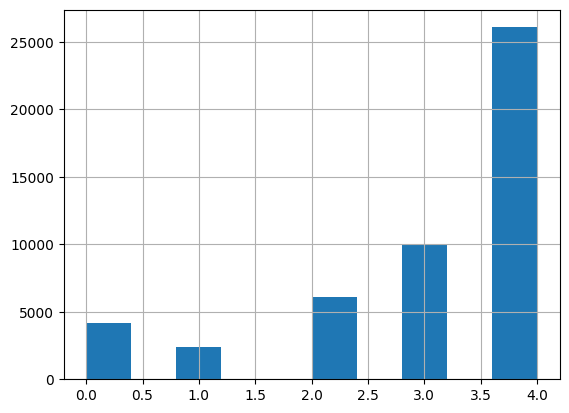

In [6]:
train_data['rate'].hist(); 

In [7]:
le = LabelEncoder()

train_data['rate'] = le.fit_transform(train_data['rate'])

# Оптимизация типов данных
train_data['rate'] = train_data['rate'].astype('uint8')

train_data.head()

,rate,text,clear_text
0,3,Очень понравилось. Были в начале марта с соба...,очень понравиться начало март собака дойти лес...
1,4,В целом магазин устраивает.\nАссортимент позво...,целое магазин устраивать ассортимент позволять...
2,4,"Очень хорошо что открылась 5 ка, теперь не над...",очень открыться ка далеко ехать рядом
3,2,Пятёрочка громко объявила о том как она заботи...,пята рочко громко объявить заботиться пенсионе...
4,2,"Тесно, вечная сутолока, между рядами трудно ра...",тесно вечный сутолока ряд трудно разойтись гря...


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48665 entries, 0 to 48664
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   rate        48665 non-null  uint8 
 1   text        48665 non-null  object
 2   clear_text  48543 non-null  object
dtypes: object(2), uint8(1)
memory usage: 808.0+ KB


# Препроцессинг

In [9]:
import re
import string

import nltk
import pymorphy2

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

# Загрузка русских стоп-слов
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')

# Инициализация анализатора pymorphy2
morph = pymorphy2.MorphAnalyzer()

# Инициализируем стеммер
stemmer = SnowballStemmer('russian')

def preprocess_text(text):
    # Удаление лишних символов и нормализация
    text = text.lower()
    
    # Удаление знаков пунктуации
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    
    # Дополнительно: удаление специальных символов или любых символов, кроме букв (латиница или кириллица)
    text = re.sub(r"[^a-zA-Zа-яА-Я\s]", " ", text)

    # Удаление множество пробелов
    text = text.replace(r'\s+','')
    
    
    # Токенизация
    tokens = word_tokenize(text, language="russian")
    
    # Удаление стоп-слов и лемматизация
    words_lemmatized = [morph.parse(word)[0].normal_form for word in tokens if word not in russian_stopwords]
    
    # Удаление стоп-слов и стемминг
    # words_stemmed = [stemmer.stem(word) for word in words if word not in russian_stopwords]
    
    return ' '.join(words_lemmatized)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:

# Предварительная обработка текста
train_data['clear_text'] = train_data['text'].apply(preprocess_text)


In [11]:
test_data['clear_text'] = train_data['text'].apply(preprocess_text)

# DataSet

In [12]:
import re
from collections import Counter
from itertools import chain
from typing import List

import torch
from torch.nn.utils.rnn import pack_sequence
from torch.utils.data import Dataset, DataLoader


class Tokenizer:
    def __init__(self, word_pattern="[\w']+"):
        """
        Simple tokenizer that splits the sentence by given regex pattern
        :param word_pattern: pattern that determines word boundaries
        """
        self.word_pattern = re.compile(word_pattern)

    def tokenize(self, text):
        return self.word_pattern.findall(text)


class Vocab:
    def __init__(self, tokenized_texts: List[List[str]], max_vocab_size=None):
        """
        Builds a vocabulary by concatenating all tokenized texts and counting words.
        Most common words are placed in vocabulary, others are replaced with [UNK] token
        :param tokenized_texts: texts to build a vocab
        :param max_vocab_size: amount of words in vocabulary
        """
        counts = Counter(chain(*tokenized_texts))
        max_vocab_size = max_vocab_size or len(counts)
        common_pairs = counts.most_common(max_vocab_size)
        self.PAD_IDX = 0
        self.UNK_IDX = 1
        self.EOS_IDX = 2
        self.itos = ["<PAD>", "<UNK>", "<EOS>"] + [pair[0]
                                                   for pair in common_pairs]
        self.stoi = {token: i for i, token in enumerate(self.itos)}

    def vectorize(self, text: List[str]):
        """
        Maps each token to it's index in the vocabulary
        :param text: sequence of tokens
        :return: vectorized sequence
        """
        return [self.stoi.get(tok, self.UNK_IDX) for tok in text]

    def __iter__(self):
        return iter(self.itos)

    def __len__(self):
        return len(self.itos)


class TextDataset(Dataset):
    def __init__(self, tokenized_texts, labels, vocab: Vocab):
        """
        A Dataset for the task
        :param tokenized_texts: texts from a train/val/test split
        :param labels: corresponding toxicity ratings
        :param vocab: vocabulary with indexed tokens
        """
        self.texts = tokenized_texts
        self.labels = labels
        self.vocab = vocab

    def __getitem__(self, item):
        return (
            self.vocab.vectorize(self.texts[item]) + [self.vocab.EOS_IDX],
            self.labels[item],
        )

    def __len__(self):
        return len(self.texts)

    def collate_fn(self, batch):
        """
        Technical method to form a batch to feed into recurrent network
        """
        tmp = pack_sequence(
            [torch.tensor(pair[0]) for pair in batch], enforce_sorted=False
        ), torch.tensor([pair[1] for pair in batch])
        return tmp


def train_test_split(data, train_frac=0.85):
    """
    Splits the data into train and test parts, stratifying by labels.
    Should it shuffle the data before split?
    :param data: dataset to split
    :param train_frac: proportion of train examples
    :return: texts and labels for each split
    """
    n_toxicity_ratings = 5
    train_labels = []
    val_labels = []
    train_texts = []
    val_texts = []
    for label in range(n_toxicity_ratings):
        texts = data[data['rate'] == label]['clear_text'].values
        n_train = int(len(texts) * train_frac)
        n_val = len(texts) - n_train
        train_texts.extend(texts[:n_train])
        val_texts.extend(texts[n_train:])
        train_labels += [label] * n_train
        val_labels += [label] * n_val
    return train_texts, train_labels, val_texts, val_labels


# Модель


In [13]:
from typing import Dict

import torch
from torch.nn.functional import sigmoid, relu, elu, tanh
from torch.nn import Module, Embedding, LSTM, RNN, GRU, Linear, Sequential, Dropout
from torch.nn.utils.rnn import PackedSequence

# from dataset import Vocab


def prepare_emb_matrix(gensim_model, vocab: Vocab):
    """
    Extract embedding matrix from Gensim model for words in Vocab.
    Initialize embeddings not presented in `gensim_model` randomly
    :param gensim_model: W2V Gensim model
    :param vocab: vocabulary
    :return: embedding matrix
    """
    mean = gensim_model.vectors.mean(1).mean()
    std = gensim_model.vectors.std(1).mean()
    vec_size = gensim_model.vector_size
    emb_matrix = torch.zeros((len(vocab), vec_size))
    for i, word in enumerate(vocab.itos[1:], 1):
        try:
            emb_matrix[i] = torch.tensor(gensim_model.get_vector(word))
        except KeyError:
            emb_matrix[i] = torch.randn(vec_size) * std + mean
    return emb_matrix


class RecurrentClassifier(Module):
    def __init__(self, config: Dict, vocab: Vocab, emb_matrix):
        """
        Baseline classifier, hyperparameters are passed in `config`.
        Consists of recurrent part and a classifier (Multilayer Perceptron) part
        Keys are:
            - freeze: whether word embeddings should be frozen
            - cell_type: one of: RNN, GRU, LSTM, which recurrent cell model should use
            - hidden_size: size of hidden state for recurrent cell
            - num_layers: amount of recurrent cells in the model
            - cell_dropout: dropout rate between recurrent cells (not applied if model has only one cell!)
            - bidirectional: boolean, whether to use unidirectional of bidirectional model
            - out_activation: one of: "sigmoid", "tanh", "relu", "elu". Activation in classifier part
            - out_dropout: dropout rate in classifier part
            - out_sizes: List[int], hidden size of each layer in classifier part. Empty list means that final
                layer is attached directly to recurrent part output
        :param config: configuration of model
        :param vocab: vocabulary
        :param emb_matrix: embeddings matrix from `prepare_emb_matrix`
        """
        super().__init__()
        self.config = config
        self.vocab = vocab
        self.emb_matrix = emb_matrix
        self.embeddings = Embedding.from_pretrained(
            emb_matrix, freeze=config["freeze"], padding_idx=vocab.PAD_IDX
        )
        cell_types = {"RNN": RNN, "GRU": GRU, "LSTM": LSTM}
        cell_class = cell_types[config["cell_type"]]
        self.cell = cell_class(
            input_size=emb_matrix.size(1),
            batch_first=True,
            hidden_size=config["hidden_size"],
            num_layers=config["num_layers"],
            dropout=config["cell_dropout"],
            bidirectional=config["bidirectional"],
        )
        activation_types = {
            "sigmoid": sigmoid,
            "tanh": tanh,
            "relu": relu,
            "elu": elu,
        }
        self.out_activation = activation_types[config["out_activation"]]
        self.out_dropout = Dropout(config["out_dropout"])
        cur_out_size = config["hidden_size"] * config["num_layers"]
        if config["bidirectional"]:
            cur_out_size *= 2
        out_layers = []
        for cur_hidden_size in config["out_sizes"]:
            out_layers.append(Linear(cur_out_size, cur_hidden_size))
            cur_out_size = cur_hidden_size
        out_layers.append(Linear(cur_out_size, 6))
        self.out_proj = Sequential(*out_layers)

    def forward(self, input):
        embedded = self.embeddings(input.data)
        _, last_state = self.cell(
            PackedSequence(
                embedded,
                input.batch_sizes,
                sorted_indices=input.sorted_indices,
                unsorted_indices=input.unsorted_indices,
            )
        )
        if isinstance(last_state, tuple):
            last_state = last_state[0]
        last_state = last_state.transpose(0, 1)
        last_state = last_state.reshape(last_state.size(0), -1)
        return self.out_proj(last_state)



# Тренер

In [14]:
from typing import Dict

import torch
from numpy import asarray
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from tqdm.notebook import tqdm

# from model import RecurrentClassifier


class Trainer:
    def __init__(self, config: Dict):
        """
        Fits end evaluates given model with Adam optimizer.
        Hyperparameters are specified in `config`
        Possible keys are:
            - n_epochs: number of epochs to train
            - lr: optimizer learning rate
            - weight_decay: l2 regularization weight
            - device: on which device to perform training ("cpu" or "cuda")
            - verbose: whether to print anything during training
        :param config: configuration for `Trainer`
        """
        self.config = config
        self.n_epochs = config["n_epochs"]
        self.setup_opt_fn = lambda model: Adam(
            model.parameters(), config["lr"], weight_decay=config["weight_decay"]
        )
        self.model = None
        self.opt = None
        self.history = None
        self.loss_fn = CrossEntropyLoss()
        self.device = config["device"]
        self.verbose = config.get("verbose", True)

    def fit(self, model, train_loader, val_loader):
        """
        Fits model on training data, each epoch evaluates on validation data
        :param model: PyTorch model for toxic comments classification (for example, `RecurrentClassifier`)
        :param train_loader: DataLoader for training data
        :param val_loader: DataLoader for validation data
        :return:
        """
        self.model = model.to(self.device)
        self.opt = self.setup_opt_fn(self.model)
        self.history = {"train_loss": [], "val_loss": [], "val_acc": []}
        for epoch in range(self.n_epochs):
            print(f"Epoch {epoch + 1}/{self.n_epochs}")
            train_info = self._train_epoch(train_loader)
            val_info = self._val_epoch(val_loader)
            self.history["train_loss"].extend(train_info["train_loss"])
            self.history["val_loss"].append(val_info["loss"])
            self.history["val_acc"].append(val_info["acc"])
        return self.model.eval()

    def _train_epoch(self, train_loader):
        self.model.train()
        losses = []
        if self.verbose:
            train_loader = tqdm(train_loader)
        for batch in train_loader:
            self.model.zero_grad()
            texts, labels = batch
            logits = self.model.forward(texts.to(self.device))
            loss = self.loss_fn(logits, labels.to(self.device))
            loss.backward()
            self.opt.step()
            loss_val = loss.item()
            if self.verbose:
                train_loader.set_description(f"Loss={loss_val:.3}")
            losses.append(loss_val)
        return {"train_loss": losses}

    def _val_epoch(self, val_loader):
        self.model.eval()
        all_logits = []
        all_labels = []
        if self.verbose:
            val_loader = tqdm(val_loader)
        with torch.no_grad():
            for batch in val_loader:
                texts, labels = batch
                logits = self.model.forward(texts.to(self.device))
                all_logits.append(logits)
                all_labels.append(labels)
        all_labels = torch.cat(all_labels).to(self.device)
        all_logits = torch.cat(all_logits)
        loss = CrossEntropyLoss()(all_logits, all_labels).item()
        acc = (all_logits.argmax(1) == all_labels).float().mean().item()
        if self.verbose:
            val_loader.set_description(f"Loss={loss:.3}; Acc:{acc:.3}")
        return {"acc": acc, "loss": loss}

    def predict(self, test_loader):
        if self.model is None:
            raise RuntimeError("You should train the model first")
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_loader:
                texts, labels = batch
                logits = self.model.forward(texts.to(self.device))
                predictions.extend(logits.argmax(1).tolist())
        return asarray(predictions)

    def save(self, path: str):
        if self.model is None:
            raise RuntimeError("You should train the model first")
        checkpoint = {
            "config": self.model.config,
            "trainer_config": self.config,
            "vocab": self.model.vocab,
            "emb_matrix": self.model.emb_matrix,
            "state_dict": self.model.state_dict(),
        }
        torch.save(checkpoint, path)

    @classmethod
    def load(cls, path: str):
        ckpt = torch.load(path)
        keys = ["config", "trainer_config",
                "vocab", "emb_matrix", "state_dict"]
        for key in keys:
            if key not in ckpt:
                raise RuntimeError(f"Missing key {key} in checkpoint")
        new_model = RecurrentClassifier(
            ckpt["config"], ckpt["vocab"], ckpt["emb_matrix"]
        )
        new_model.load_state_dict(ckpt["state_dict"])
        new_trainer = cls(ckpt["trainer_config"])
        new_trainer.model = new_model
        new_trainer.model.to(new_trainer.device)
        return new_trainer


# Выполнение

In [15]:
tok = Tokenizer()
tok_texts = [tok.tokenize(t) for t in train_data['clear_text'].values]
vocab = Vocab(tok_texts, max_vocab_size=30000)

In [16]:
train_texts, train_labels, val_texts, val_labels = train_test_split(train_data)

train_dataset = TextDataset([tok.tokenize(t)
                            for t in train_texts], train_labels, vocab)
val_dataset = TextDataset([tok.tokenize(t)
                          for t in val_texts], val_labels, vocab)

In [17]:
from gensim.models import KeyedVectors

# Путь к модели
path_to_model = DATA_PATH + '65/model.bin'

# Загрузка предварительно обученной модели (может потребовать много времени и памяти)
word_vectors = KeyedVectors.load_word2vec_format(path_to_model, binary=True)

In [18]:
os.environ["GENSIM_DATA_DIR"] = str(Path.cwd())
gensim_model = api.load("word2vec-ruscorpora-300")
emb_matrix = prepare_emb_matrix(word_vectors, vocab)

In [19]:
config = {
    "freeze": True,
    "cell_type": "LSTM",
    "cell_dropout": 0.2,
    "num_layers": 2,
    "hidden_size": 256,
    "out_activation": "relu",
    "bidirectional": True,
    "out_dropout": 0.1,
    "out_sizes": [200],
}

trainer_config = {
    "lr": 1e-3,
    "n_epochs": 10,
    "weight_decay": 1e-6,
    "batch_size": 128,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}
clf_model = RecurrentClassifier(config, vocab, emb_matrix)

In [20]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=trainer_config["batch_size"],
                              shuffle=True,
                              num_workers=0,
                              collate_fn=train_dataset.collate_fn)
val_dataloader = DataLoader(val_dataset,
                            batch_size=trainer_config["batch_size"],
                            shuffle=False,
                            num_workers=0,
                            collate_fn=val_dataset.collate_fn)
t = Trainer(trainer_config)
t.fit(clf_model, train_dataloader, val_dataloader)

Epoch 1/10


  0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 2/10


  0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 3/10


  0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 4/10


  0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 5/10


  0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 6/10


  0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 7/10


  0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 8/10


  0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 9/10


  0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 10/10


  0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

RecurrentClassifier(
  (embeddings): Embedding(22411, 100, padding_idx=0)
  (cell): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (out_dropout): Dropout(p=0.1, inplace=False)
  (out_proj): Sequential(
    (0): Linear(in_features=1024, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=6, bias=True)
  )
)

In [21]:
t.save("baseline_model.ckpt")
t = Trainer.load("baseline_model.ckpt")

In [22]:
def predict(model, text):
    tok_text = tok.tokenize(text)
    indexed_text = torch.tensor(vocab.vectorize(tok_text)).to(t.device)
    genre = model(pack_sequence([indexed_text])).argmax().item()
    return genre

In [27]:
test_dataloader = DataLoader(TextDataset([tok.tokenize(t) for t in test_data['clear_text'].values], [-1] * test_data.shape[0], vocab),
                             batch_size=trainer_config["batch_size"],
                             shuffle=False,
                             num_workers=0,
                             collate_fn=val_dataset.collate_fn)

predictions = t.predict(test_dataloader)

In [28]:
sample_submission = pd.read_csv(os.path.join(DATA_PATH, "sample_submission.csv"))
# pred_labels = le.inverse_transform(predictions)
sample_submission["rate"] = predictions
sample_submission.loc[sample_submission['rate'] == 5, 'rate'] = 4
sample_submission['rate'] = sample_submission['rate'].apply(lambda a: a + 1)

sample_submission['rate'].unique()

array([5, 4, 1, 3, 2], dtype=int64)

In [29]:
sample_submission.to_csv(DATA_PATH+"submission.csv", index=False)